In [67]:
import os

import hydra
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

import torch
import pandas as pd
import plotnine as pn

import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")
from misc.util import get_bound_fn


In [68]:
overrides = [
    "game.num_states=100",
    "game.num_signals=100",
    "simulation.dynamics.imprecise_imitation_gamma=3",
]

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

# Define a helper which lets us compose new configs since we can't use multirun
def compose(new_overrides):
    """Return a composed hydra config."""
    cfg = hydra.compose(
        config_name="config",
        overrides=overrides + new_overrides,
    )
    return cfg

In [69]:
# Filepaths

# user's path to root of repo
root_path = "/Users/nathanielimel/uci/projects/ibsg"
multirun_path = os.path.join(root_path, config.filepaths.hydra_sweep_root)

#############################################################################
# Analysis files
#############################################################################

curve_dir = os.path.join(multirun_path, config.filepaths.curve_subdir)
curve_fn = get_bound_fn(config, curve_dir=curve_dir)
mse_curve_fn = get_bound_fn(config, "mse", curve_dir=curve_dir)

#############################################################################
# Simulation points
#############################################################################

sim_sweep_subdir = os.path.join(multirun_path, config.filepaths.sim_sweep_subdir)

def get_sim_fn(discr_need: str) -> str:
    # to simulate a sweep, we can compose for each value swept
    cfg = compose([f"game.discriminative_need_gamma={discr_need}"])
    return os.path.join(multirun_path, cfg.filepaths.simulation_subdir, cfg.filepaths.simulation_points_save_fn)

get_discr_need = lambda dir: dir.split("=")[1]

sim_fns = {
    get_discr_need(dir): 
    get_sim_fn(get_discr_need(dir)) for dir in os.listdir(sim_sweep_subdir) if "=" in dir
}

sim_fns

{'0': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_runs=8/seed=42/discr_need=0/simulation_points.csv',
 '1': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_runs=8/seed=42/discr_need=1/simulation_points.csv',
 '-1': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_runs=8/seed=42/discr_need=-1/simulation_points.csv',
 '-3': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_runs=8/seed=42/discr_need=-3/simulation_points.csv',
 '3': '/Users/nathanielimel/uci/projects/ibsg/multirun/state

In [70]:
#############################################################################
# Trajectory points
#############################################################################

def get_traj_fn(discr_need: str) -> str:
    # to simulate a sweep, we can compose for each value swept
    cfg = compose([f"game.discriminative_need_gamma={discr_need}"])
    return os.path.join(multirun_path, cfg.filepaths.simulation_subdir, cfg.filepaths.trajectory_points_save_fn)

traj_fns = {
    get_discr_need(dir): 
    get_traj_fn(get_discr_need(dir)) for dir in os.listdir(sim_sweep_subdir) if "=" in dir
}
traj_fns

{'0': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_runs=8/seed=42/discr_need=0/trajectory_points.csv',
 '1': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_runs=8/seed=42/discr_need=1/trajectory_points.csv',
 '-1': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_runs=8/seed=42/discr_need=-1/trajectory_points.csv',
 '-3': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=100/signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_runs=8/seed=42/discr_need=-3/trajectory_points.csv',
 '3': '/Users/nathanielimel/uci/projects/ibsg/multirun/state

In [71]:
# load dataframes
read = lambda fn: pd.read_csv(os.path.join(root_path, fn))
curve_data = read(curve_fn)
ub_curve_data = read(mse_curve_fn)

sim_dfs = {k: read(sim_fns[k]) for k in sim_fns}

traj_dfs = {k: read(traj_fns[k]) for k in traj_fns}

In [72]:
# label each df to be concatenated with a columns

def label_discr_need(dfs):
    for key in dfs:
        df = dfs[key]
        df["discr_need"] = key

label_discr_need(sim_dfs)
label_discr_need(traj_dfs)

sim_data = pd.concat(sim_dfs.values())
traj_data = pd.concat(traj_dfs.values())

In [73]:
sim_data["discr_need"] = sim_data["discr_need"].astype(float)
sim_data # N.B.: nans are expected for 'round' column

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,discr_need
0,6.369271e+00,5.034521e+00,0.077149,1.113243,1.903211e-02,-1.716458e-02,3.332228,0,0.0
1,6.303815e+00,5.012905e+00,0.098765,1.156318,2.374558e-02,-2.133410e-02,3.165784,1,0.0
2,6.375398e+00,5.030621e+00,0.081050,1.134050,1.911437e-02,-1.386058e-02,3.325570,2,0.0
3,6.290070e+00,5.004857e+00,0.106813,1.178900,2.650990e-02,-2.313328e-02,3.165784,3,0.0
4,4.934728e+00,3.605722e+00,1.505948,469.624976,2.146883e-01,3.320540e-01,1.797612,4,0.0
5,1.407651e+00,8.865268e-01,4.225145,1414.515515,6.971996e-01,6.615613e-01,0.725710,5,0.0
6,1.639785e+00,1.017497e+00,4.094173,1457.558958,7.087889e-01,8.009608e-01,0.725710,6,0.0
7,1.035081e+00,6.465431e-01,4.465127,1555.381514,7.563148e-01,4.816516e-01,0.722382,7,0.0
0,6.403856e+00,4.886295e+00,0.225376,173.764145,2.128641e-02,2.864616e-02,3.488686,0,1.0
1,6.396308e+00,4.864123e+00,0.247548,300.720062,2.223003e-02,3.406224e-02,3.465384,1,1.0


In [74]:
traj_data["discr_need"] = traj_data["discr_need"].astype(float)
traj_data # N.B.: nans are NOT expected for 'round' column

,complexity,accuracy,distortion,mse,round,run,discr_need
0,0.000069,0.000028,5.111643,1666.3732,0.0,1.0,0.0
1,0.000096,0.000048,5.111623,1666.3715,1.0,1.0,0.0
2,0.000351,0.000240,5.111430,1666.3500,2.0,1.0,0.0
3,0.001765,0.001403,5.110268,1666.2013,3.0,1.0,0.0
4,0.010009,0.008533,5.103137,1665.1672,4.0,1.0,0.0
...,...,...,...,...,...,...,...
1031,5.722466,4.220088,0.891582,780.0825,2.0,7.0,-2.0
1032,5.722466,4.220088,0.891582,780.0825,3.0,7.0,-2.0
1033,5.722466,4.220088,0.891582,780.0825,4.0,7.0,-2.0
1034,5.631272,4.106007,1.005664,666.5406,0.0,8.0,-2.0


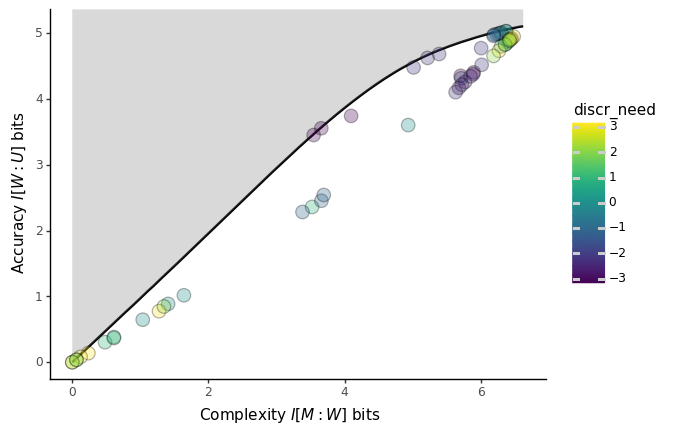

In [75]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_jitter( # emergent langs
        data=sim_data,
        mapping=pn.aes(
            fill="discr_need",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

## Trajectories

In [76]:
traj_data["iteration"] = traj_data["round"]

### First, confirm all trajectories

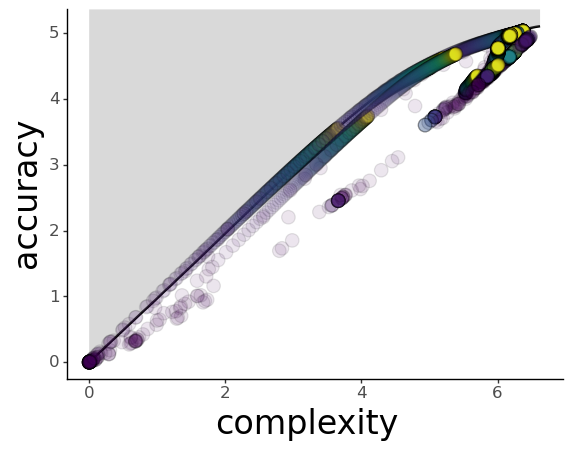

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: traj_figure


In [77]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_jitter( # emergent langs
        data=traj_data,
        mapping=pn.aes(
            fill="iteration",
            # shape="language",
            ),
        alpha=0.1,
        size=5,
    )
    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.4),
        legend_position='none',
    )        
)
print(plot)
plot.save("traj_figure", width=10, height=10, dpi=300,)

## Extract the run we want
trial 5, discr_need 0

In [78]:
discr_need_0_data = traj_data[traj_data["discr_need"] == 0.0]
single_run_data = discr_need_0_data[discr_need_0_data["run"] == 8.0]
single_run_data

,complexity,accuracy,distortion,mse,round,run,discr_need,iteration
621,5.875916,4.393243,0.718428,464.03732,0.0,8.0,0.0,0.0
622,1.221038,0.764741,4.346929,1535.08810,1.0,8.0,0.0,1.0
623,1.035081,0.646543,4.465128,1555.38150,2.0,8.0,0.0,2.0


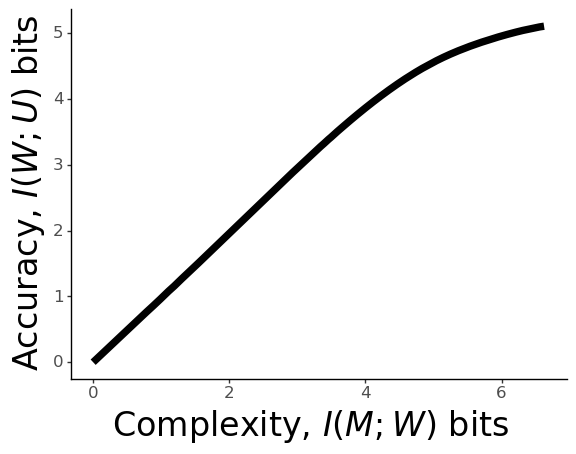

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: curve


In [79]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    # + pn.geom_point(size=1)
    # + pn.geom_ribbon(
    # mapping=pn.aes(
    #     x="complexity",
    #     ymin="accuracy",
    #     ymax=torch.inf,
    #     ),
    #     fill="gray",
    #     alpha=0.3,
    # )
    # + pn.geom_jitter( # emergent langs
    #     data=single_run_data,
    #     mapping=pn.aes(
    #         fill="iteration",
    #         # shape="language",
    #         # color="round",
    #         ),
    #     alpha=0.3,
    #     size=5,
    # )        
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")    
    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.4),
        legend_position='none',
    )    
)
print(plot)
# plot.save("single_traj", width=10, height=10, dpi=300,)
plot.save("curve", width=10, height=10, dpi=300,)